In [ ]:
# Paper: Beyond Accuracy: Behavioral Testing of NLP Models with CheckList ACL 2020

# One sentence summary:
# Method to test the behaviour of NLP models through different experiments on small
# manufactured example test sets.

# Criticism:
# The authors focus mainly on English NLP models and show that the CheckList analyses
# uncover errors in commercial and openly available models. However, there is a wide usage
# of multilingual models in the NLP community for multilingual or low-resource experiments
# which makes an error analysis of multilingual models relevant and interesting.

# Planned Implementation:
# The plan is to take a multilingual model (e.g., mBERT) and create a Minimum Functionality
# Test (MFT) for testing how the model handles negations in parallel Sentiment Analysis
# sentences in English (like "It was bad.", "It was good.", "It was not good."), German ("Es war
# schlecht.", "Es war gut.", "Es war nicht gut.") and Bavarian ("Des war schlecht.", "Des war
# guad.", "Des war ned guad."). The experiments should then show whether the CheckList
# methods can also be used in a multilingual setup and whether mBERT's behaviour changes
# for different languages.

# Feedback:
# The proposal extends CheckList to other languages and implements a Minimum Functionality Test comparing English, German and Bavarian.
# Looks good. Approved.

In [ ]:
# research questions:
# can CheckList be applied to multilingual models? (only tested on English models)
# can CheckList be used to compare model capabilities across languages? (here: has the model different behaviour when handling negations in different languages)
# does CheckList only work for encoder-based models or also for decoder-based models like llama?

In [ ]:
# sources

# code for data creation partly taken from 
# https://github.com/marcotcr/checklist/blob/master/notebooks/tutorials/1.%20Generating%20data.ipynb
# with major changes

# code for test creation and execution partly taken from
# https://github.com/marcotcr/checklist/blob/master/notebooks/tutorials/3.%20Test%20types%2C%20expectation%20functions%2C%20running%20tests.ipynb and
# https://github.com/marcotcr/checklist/blob/master/notebooks/tutorials/4.%20The%20CheckList%20process.ipynb and 
# https://github.com/marcotcr/checklist/blob/master/notebooks/Test%20Suite%20Examples.ipynb
# with major changes

# code for confusion matrix visualisations partly taken from
# https://matplotlib.org/stable/api/pyplot_summary.html and
# https://www.w3schools.com/python/python_ml_confusion_matrix.asp
# with minor changes

In [ ]:
# notes
# hard to find parallel adjective pairs where standard German and Bavarian are different -> focus on only three pairs per sentiment

# test sentences only work with predicative adjective constructions to avoid issues with inflection of the pre-chosen adjectives in standard German and Bavarian

# the tests give a good first glance at the performance, but no further error informations. 
# further visualisations: confusion matrix to see which labels were wrongly predicted as which other label
# no out-of-the-box method to access all fails, that would be handy

# running the suite with a prediction function does not allow for access to the scores, so if you need the scores themselves, you have to predict to a file
# and run the suite from the file, so that you can use the scores for further analyses again later too

# result analysis English:
# some fails have to do with weather. in those cases, the sentences are labeled as neutral instead of negative. it is actually debatable if this is a fail, since
# the perception of weather is very subjective and - unless it's a natural disaster - there is no "objectively bad" weather. in the context of this test it is
# questionable whether this is a true fail or rather a design fail of the test
# sents with "stupid" tend to be labeled as negative
# the model has problems with the 4th experiment (making negative sentences positive with positive phrases)
#
# Q: do these errors show in German and Bavarian?
#

In [ ]:
# # if pip installation of CheckList fails, execute this cell
# %%bash
# git clone https://github.com/marcotcr/checklist.git
# cd checklist/
# pip install -e .

In [ ]:
# # for modernbert model install this transformers version
# !pip install "git+https://github.com/huggingface/transformers.git@6e0515e99c39444caae39472ee1b2fd76ece32f1" --upgrade

In [25]:
from checklist.editor import Editor
from checklist.test_types import MFT
from checklist.test_suite import TestSuite
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [26]:
# initialise CheckList Editor objects
eng_editor = Editor() # default language = English
deu_editor = Editor(language="german")

# initialise CheckList TestSuite for running the tests
eng_suite = TestSuite()
deu_suite = TestSuite()
bar_suite = TestSuite()

In [27]:
# linguistic resources
# words chosen from the CheckList Editor suggestions

# parallel adjective lists for data creation
eng_pos = ["good", "nice", "great"]
deu_pos = ["gut", "schön", "super"]
bar_pos = ["guad", "schee", "subba"]

eng_neg = ["bad", "boring", "stupid"]
deu_neg = ["schlecht", "langweilig", "blöd"]
bar_neg = ["schlecht", "fad", "bled"]

# parallel noun lists for data creation
# picked from Editor suggestions in such a way that mostly all words are different
eng_noun = ["game", "site", "picture", "book", "story", "man", "world", "city", "time", "weather", "life"]

# standard German and Bavarian examples with determiners to avoid errors
deu_noun = [
    ("Das", "Spiel"), ("Die", "Seite"), ("Das", "Bild"), ("Das", "Buch"), ("Die", "Geschichte"), 
    ("Der", "Mann"), ("Die", "Welt"), ("Die", "Stadt"), ("Die", "Zeit"), ("Das", "Wetter"), ("Das", "Leben")
    ]
deu_noun_lower = [
    ("das", "Spiel"), ("die", "Seite"), ("das", "Bild"), ("das", "Buch"), ("die", "Geschichte"), 
    ("der", "Mann"), ("die", "Welt"), ("die", "Stadt"), ("die", "Zeit"), ("das", "Wetter"), ("das", "Leben")
    ]

# bavarian determiners are with spaces to handle "d'" and "s'" determiners
bar_noun = [
    ("Des ", "Spui"), ("De ", "Seitn"), ("Des ", "Buidl"), ("Des ", "Buach"), ("De ", "Gschicht"), 
    ("Der ", "Mo"), ("D'", "Weid"), ("D'", "Stod"), ("D'", "Zeid"), ("S'", "Weda"), ("S'", "Lebm")
    ] 
bar_noun_lower = [
    ("des ", "Spui"), ("de ", "Seitn"), ("des ", "Buidl"), ("des ", "Buach"), ("de ", "Gschicht"), 
    ("der ", "Mo"), ("d'", "Weid"), ("d'", "Stod"), ("d'", "Zeid"), ("s'", "Weda"), ("s'", "Lebm")
    ] 

# negative phrases
eng_neg_p = ["I hate that", "I don't like that"]
deu_neg_p = ["Ich hasse, dass", "Ich mag nicht, dass"]
bar_neg_p = ["I hass des, wenn", "I mog des ned, wenn"] # bavarian constructions work a bit differently than standard German

# positive phrases
eng_pos_p = ["I like that", "I love that"]
deu_pos_p = ["Ich mag, dass", "Ich liebe, dass"]
bar_pos_p = ["I mog des, wenn", "I liebs, wenn"]

## Word Suggestions

In [5]:
# get adj suggestions from the CheckList Editors in German and English
print("English adj suggestions: ")
print(eng_editor.suggest("This is a {mask} {noun}.", noun=["book", "movie"])[:20], "\n") 

print("German adj suggestions: ")
print(deu_editor.suggest("Das ist ein {mask} Buch.")[:20]) 
print(deu_editor.suggest("Das ist ein {mask} Film.")[:20])

English adj suggestions: 
['great', 'good', 'wonderful', 'beautiful', 'fantastic', 'terrible', 'fascinating', 'big', 'nice', 'bad', 'long', 'fun', 'scary', 'terrific', 'tough', 'short', 'serious', 'huge', 'remarkable', 'new'] 

German adj suggestions: 
['gutes', 'neues', 'großes', 'kleines', 'starkes', 'politisches', 'anderes', 'wichtiges', 'ganzes', 'besonderes', 'altes', 'deutsches', 'eigenes', 'super', 'weiteres', 'solches', 'zweites', 'einziges', 'letztes', 'erstes']
['guter', 'schlechter', 'großer', 'schöner', 'super', 'wichtiger', 'deutscher', 'schwieriger', 'historischer', 'neuer', 'kleiner', 'politischer', 'typischer', 'anderer', 'besonderer', 'amerikanischer', 'klassischer', 'einfacher', 'internationaler', 'langer']


In [5]:
# get noun suggestions from the CheckList Editors in German and English
# english suggestions
print("English noun suggestions: ")
print(eng_editor.suggest("This {mask} is {pos}.", pos=eng_pos)[:10]) 
print(eng_editor.suggest("This {mask} is {neg}.", neg=eng_neg)[:10], "\n") 

# suggestions for standard German with different determiners
print("German noun suggestions: ")
print("Der", deu_editor.suggest("Der {mask} ist {pos}.", pos=deu_pos)[:10])
print("Der", deu_editor.suggest("Der {mask} ist {neg}.", neg=deu_neg)[:10])
print("Die", deu_editor.suggest("Die {mask} ist {pos}.", pos=deu_pos)[:10])
print("Die", deu_editor.suggest("Die {mask} ist {neg}.", neg=deu_neg)[:10])
print("Das", deu_editor.suggest("Das {mask} ist {pos}.", pos=deu_pos)[:10])
print("Das", deu_editor.suggest("Das {mask} ist {neg}.", neg=deu_neg)[:10])

English noun suggestions: 
['game', 'one', 'stuff', 'book', 'article', 'video', 'post', 'movie', 'code', 'thing']
['post', 'article', 'game', 'stuff', 'video', 'movie', 'list', 'shit', 'thing', 'book'] 

German noun suggestions: 
Der ['Preis', 'Job', 'Platz', 'Service', 'Abend', 'Wind', 'Rest', 'Sieg', 'Auftritt', 'Eindruck']
Der ['Rest', 'Job', 'Film', 'Ton', 'Fußball', 'Mann', 'Preis', 'Markt', 'Anfang', 'Fall']
Die ['Stimmung', 'Atmosphäre', 'Situation', 'Sache', 'Resonanz', 'Lage', 'Idee', 'Antwort', 'Qualität', 'Zusammenarbeit']
Die ['Stimmung', 'Sache', 'Situation', 'Lage', 'Welt', 'Idee', 'Musik', 'Antwort', 'Geschichte', 'Zeit']
Das ['Ergebnis', 'Wetter', 'alles', 'Leben', 'Angebot', 'hier', 'Spiel', 'Resultat', 'Stadion', 'Essen']
Das ['Ergebnis', 'alles', 'Wetter', 'Leben', 'aber', 'Spiel', 'Ganze', 'hier', 'Auto', 'Geschäft']


## Test Creation

In [28]:
# Sanity tests
# English
data = eng_editor.template("The {noun} is {adj}.", noun=eng_noun, adj=eng_pos, labels=2) # positive samples
data += eng_editor.template("The {noun} is {adj}.", noun=eng_noun, adj=eng_neg, labels=0) # negative samples
test = MFT(**data)
eng_suite.add(test, "ENG: Sanity Check", "Negation", "Simple positive and negative sentences.", overwrite=True)

# German
data = deu_editor.template("{detnoun[0]} {detnoun[1]} ist {adj}.", detnoun=deu_noun, adj=deu_pos, labels=2) # positive samples
data += eng_editor.template("{detnoun[0]} {detnoun[1]} ist {adj}.", detnoun=deu_noun, adj=deu_neg, labels=0) # negative samples
test = MFT(**data)
deu_suite.add(test, "DEU: Sanity Check", "Negation", "Simple positive and negative sentences.", overwrite=True)

# Bavarian
data = deu_editor.template("{detnoun[0]}{detnoun[1]} is {adj}.", detnoun=bar_noun, adj=bar_pos, labels=2) # positive samples
data += eng_editor.template("{detnoun[0]}{detnoun[1]} is {adj}.", detnoun=bar_noun, adj=bar_pos, labels=0) # negative samples
test = MFT(**data)
bar_suite.add(test, "BAR: Sanity Check", "Negation", "Simple positive and negative sentences.", overwrite=True)

In [29]:
# English tests

# test for negated positive examples, expectation: negative (0)
# e.g. The game is not good.
data01 = eng_editor.template("The {noun} is not {adj}.", noun=eng_noun, adj=eng_pos, labels=0) # not pos = negative
test = MFT(**data01)
eng_suite.add(test, "ENG: Positive Adjective Negations --> Negative", "Negation", "Sentences with negated positive adjectives.", overwrite=True)

# test for negations of positive phrases, expectation: negative (0)
# e.g. I hate that the game is good.
data02 = eng_editor.template("{p} the {noun} is {adj}.", p=eng_neg_p, noun=eng_noun, adj=eng_pos, labels=0)
test = MFT(**data02)
eng_suite.add(test, "ENG: Positive Phrase Negations --> Negative", "Negation", "Negations of positive sentences.", overwrite=True)

# test for negated negative adjectives, expectation: positive (1) (or 2)
# e.g. The game is not bad.
data03 = eng_editor.template("The {noun} is not {adj}.", noun=eng_noun, adj=eng_neg, labels=2) # not neg = positive
test = MFT(**data03)
eng_suite.add(test, "ENG: Negative Adjective Negations --> Positive", "Negation", "Sentences with negated negative adjectives.", overwrite=True)

# test for positive additional phrases to negative phrases, expectation: positive (1) (or 2)
# e.g. I like that the game is bad.
data04 = eng_editor.template("{p} the {noun} is {adj}.", p=eng_pos_p, noun=eng_noun, adj=eng_neg, labels=2)
test = MFT(**data04)
eng_suite.add(test, "ENG: Negative Phrases with Positive Additions --> Positive", "Negation", "Positive additions to negative sentences.", overwrite=True)

In [30]:
# German tests

# test for negated positive examples, expectation: negative (0)
# e.g. Das Spiel ist nicht gut.
data = deu_editor.template("{detnoun[0]} {detnoun[1]} ist nicht {adj}.", detnoun=deu_noun, adj=deu_pos, labels=0) # not pos = negative
test = MFT(**data)
deu_suite.add(test, "DEU: Positive Adjective Negations --> Negative", "Negation", "Sentences with negated positive adjectives in Standard German.", overwrite=True)

# test for negations of positive phrases, expectation: negative (0)
# e.g. Ich hasse, dass das Spiel gut ist.
data = deu_editor.template("{p} {detnoun[0]} {detnoun[1]} {adj} ist.", p=deu_neg_p, detnoun=deu_noun_lower, adj=deu_pos, labels=0)
test = MFT(**data)
deu_suite.add(test, "DEU: Positive Phrase Negations --> Negative", "Negation", "Negations of positive sentences in Standard German.", overwrite=True)

# test for negated negative adjectives, expectation: positive (1) (or 2)
# e.g. Das Spiel ist nicht schlecht.
data = deu_editor.template("{detnoun[0]} {detnoun[1]} ist nicht {adj}.", detnoun=deu_noun, adj=deu_neg, labels=2) # not neg = positive
test = MFT(**data)
deu_suite.add(test, "DEU: Negative Adjective Negations --> Positive", "Negation", "Sentences with negated negative adjectives in Standard German.", overwrite=True)

# test for positive additional phrases to negative phrases, expectation: positive (1) (or 2)
# e.g. Ich mag, dass das Spiel schlecht ist.
data = deu_editor.template("{p} {detnoun[0]} {detnoun[1]} {adj} ist.", p=deu_pos_p, detnoun=deu_noun_lower, adj=deu_neg, labels=2)
test = MFT(**data)
deu_suite.add(test, "DEU: Negative Phrases with Positive Additions --> Positive", "Negation", "Positive additions to negative sentences in Standard German.", overwrite=True)

In [31]:
# Bavarian tests

# test for negated positive examples, expectation: negative (0)
# e.g. Des Spui is ned guad.
data = deu_editor.template("{detnoun[0]}{detnoun[1]} is ned {adj}.", detnoun=bar_noun, adj=bar_pos, labels=0) # not pos = negative
test = MFT(**data)
bar_suite.add(test, "BAR: Positive Adjective Negations --> Negative", "Negation", "Sentences with negated positive adjectives in Bavarian.", overwrite=True)

# test for negations of positive phrases, expectation: negative (0)
# e.g. I hass des, wenn des Spui guad ist.
data = deu_editor.template("{p} {detnoun[0]}{detnoun[1]} {adj} ist.", p=bar_neg_p, detnoun=bar_noun_lower, adj=bar_pos, labels=0)
test = MFT(**data)
bar_suite.add(test, "BAR: Positive Phrase Negations --> Negative", "Negation", "Negations of positive sentences in Bavarian.", overwrite=True)

# test for negated negative adjectives, expectation: positive (1) (or 2)
# e.g. Des Spui ist nicht schlecht.
data = deu_editor.template("{detnoun[0]}{detnoun[1]} ist nicht {adj}.", detnoun=bar_noun, adj=bar_neg, labels=2) # not neg = positive
test = MFT(**data)
bar_suite.add(test, "BAR: Negative Adjective Negations --> Positive", "Negation", "Sentences with negated negative adjectives in Bavarian.", overwrite=True)

# test for positive additional phrases to negative phrases, expectation: positive (1) (or 2)
# e.g. I mog des, wenn des Spui schlecht ist.
data = deu_editor.template("{p} {detnoun[0]}{detnoun[1]} {adj} ist.", p=bar_pos_p, detnoun=bar_noun_lower, adj=bar_neg, labels=2)
test = MFT(**data)
bar_suite.add(test, "BAR: Negative Phrases with Positive Additions --> Positive", "Negation", "Positive additions to negative sentences in Bavarian.", overwrite=True)

## Model Predictions Generation

### with modernBERT = encoder-based model

In [32]:
# load multilingual sentiment analysis model
model_name = "clapAI/modernBERT-base-multilingual-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# initialise pipeline for predictions
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_float32_matmul_precision("high") # for better performance with TensorFloat32 tensor cores
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device, top_k=None)

idx2lbl = model.config.id2label
lbl2idx = model.config.label2id
print(lbl2idx)
print(idx2lbl)

# functions for predictions and running the TestSuites
def predict_to_file(data, preds):
    # read data and predict
    with open(data, "r") as f:
        data = [line.strip() for line in f.readlines()]
    
    raw_preds = pipe(data)

    # write results in correct CheckList format to a file
    with open(preds, "w") as f:
        f.write("prediction positive neutral negative\n")
        for result in raw_preds:
            positive = result[0]
            neutral = result[1]
            negative = result[2]

            max_pred = max([negative, positive, neutral], key=lambda x: x["score"])
            max_label = max_pred["label"]

            f.write(f"{lbl2idx[max_label]} {positive["score"]} {neutral["score"]} {negative["score"]}\n")

Device set to use cuda


{'negative': 0, 'neutral': 1, 'positive': 2}
{0: 'negative', 1: 'neutral', 2: 'positive'}


In [33]:
# Generate English predictions
eng_data_file = "/tmp/eng_data.txt"
eng_predictions_file = "/tmp/eng_predictions_bert.txt"

eng_suite.to_raw_file(eng_data_file)
predict_to_file(eng_data_file, eng_predictions_file)

In [34]:
# Generate German predictions
deu_data_file = "/tmp/deu_data.txt"
deu_predictions_file = "/tmp/deu_predictions_bert.txt"

deu_suite.to_raw_file(deu_data_file)
predict_to_file(deu_data_file, deu_predictions_file)

In [35]:
# Generate Bavarian predictions
bar_data_file = "/tmp/bar_data.txt"
bar_predictions_file = "/tmp/bar_predictions_bert.txt"

bar_suite.to_raw_file(bar_data_file)
predict_to_file(bar_data_file, bar_predictions_file)

## CheckList Testing

In [36]:
def format_example(x, pred, conf, label, meta=None): 
    return f"Sentence: {x}\nGold: {idx2lbl[label]}\tPredicted: {idx2lbl[pred]}\tScore = {round(conf[0], 2)}"

In [37]:
# Run English TestSuite
eng_suite.run_from_file(eng_predictions_file, file_format="pred_and_softmax", ignore_header=True, overwrite=True)

eng_suite.summary(format_example_fn = format_example)

Negation

ENG: Sanity Check
Test cases:      66
Fails (rate):    3 (4.5%)

Example fails:
Sentence: The weather is boring.
Gold: negative	Predicted: neutral	Score = 0.51
----
Sentence: The weather is bad.
Gold: negative	Predicted: neutral	Score = 0.57
----
Sentence: The weather is good.
Gold: positive	Predicted: neutral	Score = 0.49
----


ENG: Positive Adjective Negations --> Negative
Test cases:      33
Fails (rate):    3 (9.1%)

Example fails:
Sentence: The weather is not nice.
Gold: negative	Predicted: neutral	Score = 0.66
----
Sentence: The weather is not great.
Gold: negative	Predicted: neutral	Score = 0.74
----
Sentence: The weather is not good.
Gold: negative	Predicted: neutral	Score = 0.63
----


ENG: Positive Phrase Negations --> Negative
Test cases:      66
Fails (rate):    3 (4.5%)

Example fails:
Sentence: I hate that the weather is great.
Gold: negative	Predicted: neutral	Score = 0.53
----
Sentence: I hate that the weather is nice.
Gold: negative	Predicted: neutral	Score 

In [38]:
# Run German TestSuite
deu_suite.run_from_file(deu_predictions_file, file_format="pred_and_softmax", ignore_header=True, overwrite=True)

deu_suite.summary(format_example_fn = format_example)

Negation

DEU: Sanity Check
Test cases:      66
Fails (rate):    0 (0.0%)


DEU: Positive Adjective Negations --> Negative
Test cases:      33
Fails (rate):    1 (3.0%)

Example fails:
Sentence: Das Wetter ist nicht super.
Gold: negative	Predicted: neutral	Score = 0.5
----


DEU: Positive Phrase Negations --> Negative
Test cases:      66
Fails (rate):    35 (53.0%)

Example fails:
Sentence: Ich hasse, dass das Bild super ist.
Gold: negative	Predicted: positive	Score = 0.87
----
Sentence: Ich hasse, dass die Zeit super ist.
Gold: negative	Predicted: positive	Score = 0.9
----
Sentence: Ich hasse, dass das Spiel super ist.
Gold: negative	Predicted: positive	Score = 0.82
----


DEU: Negative Adjective Negations --> Positive
Test cases:      33
Fails (rate):    2 (6.1%)

Example fails:
Sentence: Das Bild ist nicht schlecht.
Gold: positive	Predicted: neutral	Score = 0.49
----
Sentence: Das Bild ist nicht langweilig.
Gold: positive	Predicted: negative	Score = 0.42
----


DEU: Negative Phrases

In [39]:
# Run Bavarian TestSuite
bar_suite.run_from_file(bar_predictions_file, file_format="pred_and_softmax", ignore_header=True, overwrite=True)

bar_suite.summary(format_example_fn = format_example)

Negation

BAR: Sanity Check
Test cases:      66
Fails (rate):    37 (56.1%)

Example fails:
Sentence: S'Weda is subba.
Gold: positive	Predicted: negative	Score = 0.82
----
Sentence: Des Buach is schee.
Gold: positive	Predicted: negative	Score = 0.62
----
Sentence: D'Weid is guad.
Gold: positive	Predicted: negative	Score = 0.47
----


BAR: Positive Adjective Negations --> Negative
Test cases:      33
Fails (rate):    33 (100.0%)

Example fails:
Sentence: S'Weda is ned subba.
Gold: negative	Predicted: neutral	Score = 0.99
----
Sentence: Der Mo is ned guad.
Gold: negative	Predicted: neutral	Score = 1.0
----
Sentence: D'Weid is ned subba.
Gold: negative	Predicted: neutral	Score = 1.0
----


BAR: Positive Phrase Negations --> Negative
Test cases:      66
Fails (rate):    3 (4.5%)

Example fails:
Sentence: I mog des ned, wenn der Mo subba ist.
Gold: negative	Predicted: neutral	Score = 0.68
----
Sentence: I mog des ned, wenn d'Stod subba ist.
Gold: negative	Predicted: neutral	Score = 0.53
---

## Further Analyses

In [40]:
# show all fails instead of only the three example fails

def show_all_fails(testsuite):
    for test_name, test in testsuite.tests.items():
        test_results = test.results
        test_data = list(enumerate(test.data))

        print(f"\nTest: {test_name}")

        for i, text in test_data:
            pred_label = idx2lbl[test_results["preds"][i]]
            pred_score = round(test_results["confs"][i][0], 2)

            if test_results["passed"][i] == False:
                print(f"Predicted: {pred_label}\t\tScore: {pred_score}\t\tText: {text}")

show_all_fails(eng_suite)
show_all_fails(deu_suite)
show_all_fails(bar_suite)


Test: ENG: Sanity Check
Predicted: neutral		Score: 0.49		Text: The weather is good.
Predicted: neutral		Score: 0.57		Text: The weather is bad.
Predicted: neutral		Score: 0.51		Text: The weather is boring.

Test: ENG: Positive Adjective Negations --> Negative
Predicted: neutral		Score: 0.63		Text: The weather is not good.
Predicted: neutral		Score: 0.66		Text: The weather is not nice.
Predicted: neutral		Score: 0.74		Text: The weather is not great.

Test: ENG: Positive Phrase Negations --> Negative
Predicted: neutral		Score: 0.55		Text: I hate that the weather is good.
Predicted: neutral		Score: 0.56		Text: I hate that the weather is nice.
Predicted: neutral		Score: 0.53		Text: I hate that the weather is great.

Test: ENG: Negative Adjective Negations --> Positive
Predicted: negative		Score: 0.68		Text: The site is not stupid.
Predicted: negative		Score: 0.5		Text: The picture is not stupid.
Predicted: neutral		Score: 0.41		Text: The man is not bad.
Predicted: neutral		Score: 0.43		Tex

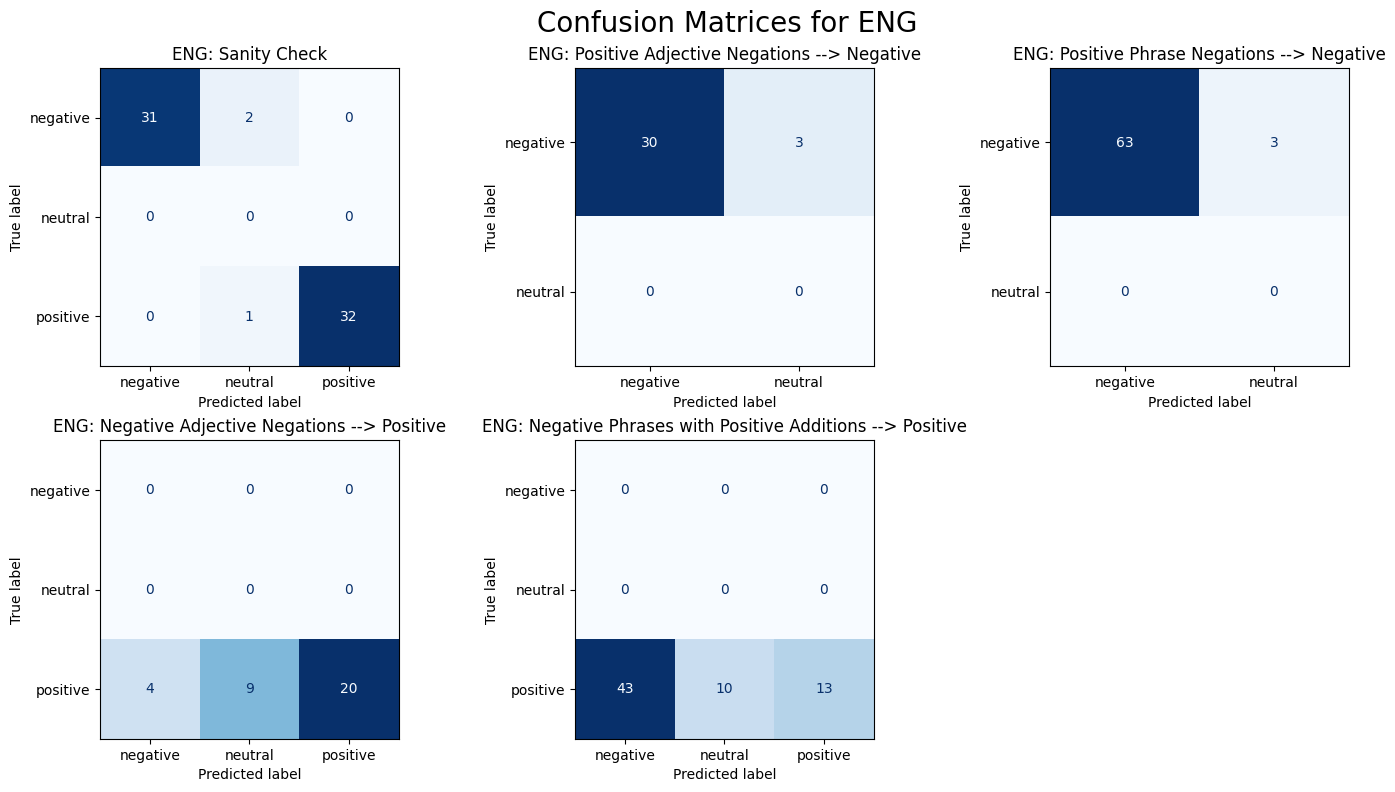

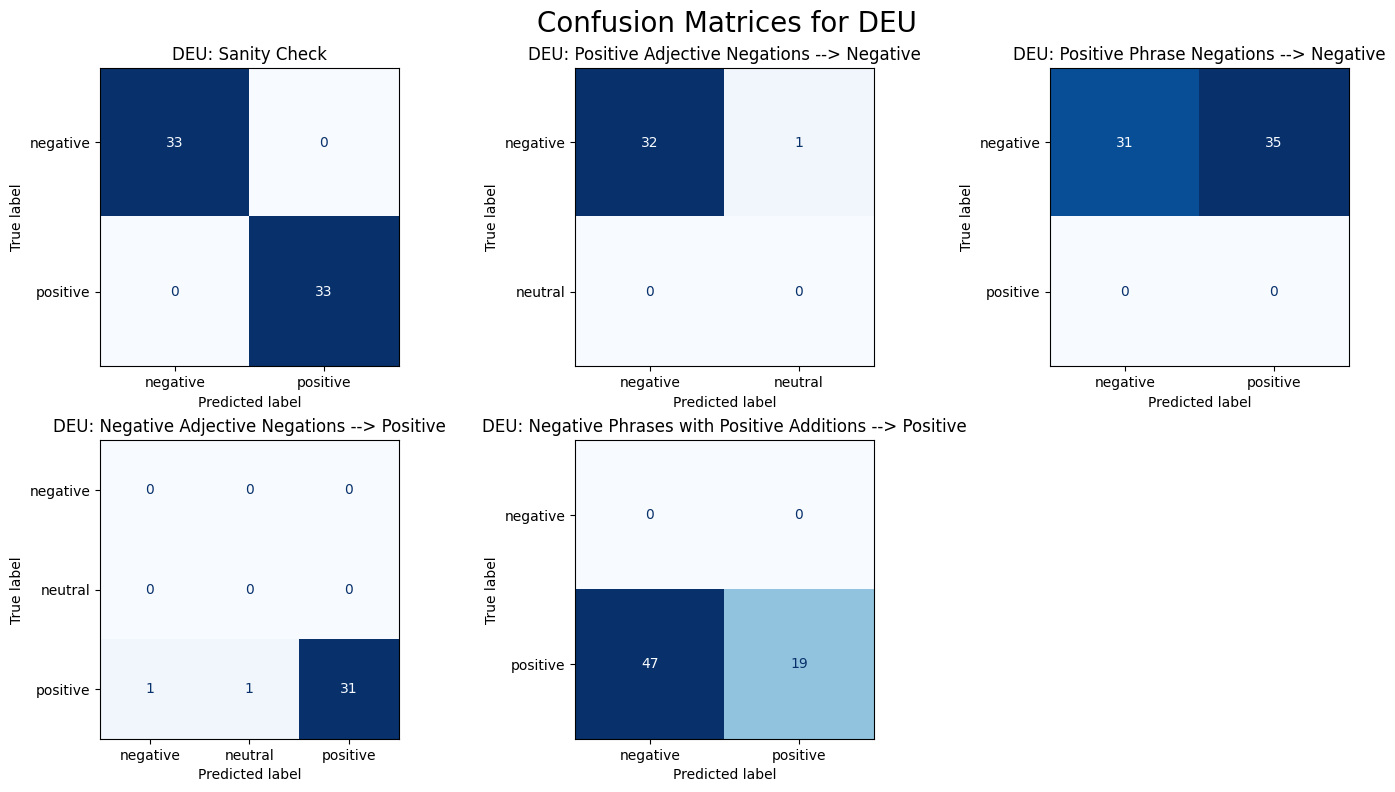

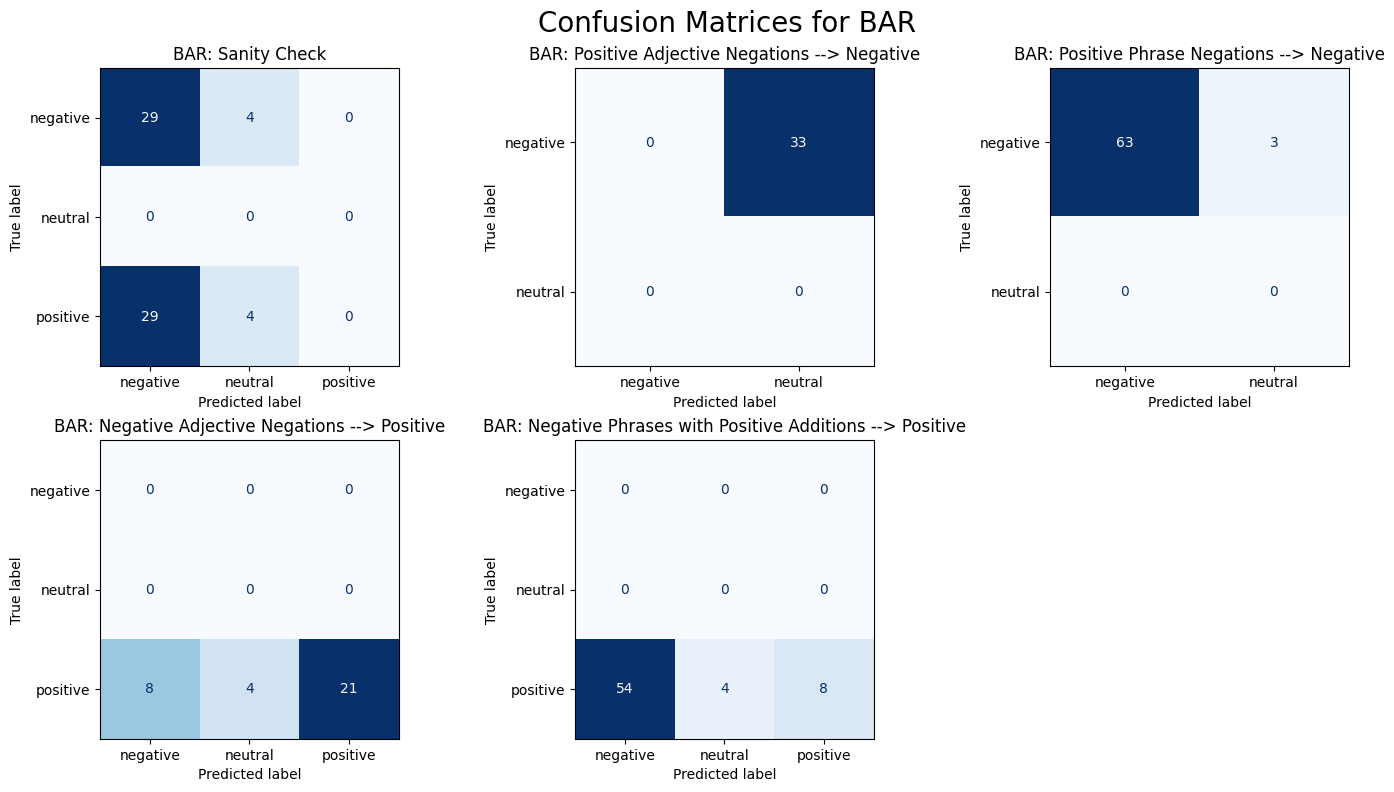

In [41]:
def visualise_cm(testsuite):
    # create figure with a subplot for each test
    test_names = list(testsuite.tests.keys())
    n_tests = len(test_names)

    # calculate rows and columns for the figure
    rows = int(np.sqrt(n_tests))
    cols = int(math.ceil(n_tests / rows))

    # create a figure for with rows x cols subplots
    _, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten() # for easy indexing

    # subplot(row, col, curr_plot)
    for idx, (test_name, test) in enumerate(testsuite.tests.items()):
        gold_labels = [idx2lbl[label] for label in test.labels] # convert to lexical labels for better readability
        pred_labels = [idx2lbl[label] for label in test.results["preds"]]
        
        # classes = list(lbl2idx.keys())
        classes = sorted(set(gold_labels + pred_labels)) # include all occuring labels

        cm = confusion_matrix(gold_labels, pred_labels)
        
        plt.subplot(rows, cols, idx+1)

        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        cm_disp.plot(ax=axes[idx], cmap="Blues", colorbar=False)

        axes[idx].set_title(f"{test_name}")
    
    for i in range(len(testsuite.tests), len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1.2, 0.95]) # bottom, left, right, and top spacing
    plt.suptitle(f"Confusion Matrices for {test_names[0][:3]}", x=0.64, fontsize=20)
    plt.show()

visualise_cm(eng_suite)
visualise_cm(deu_suite)
visualise_cm(bar_suite)